In [1]:
from src.utils.input import *
%run "docs\src\utils\notebook_style.ipynb"


In [2]:
params_krummung, params_zustandslinien, Laststufen = load_params_A3()

In [3]:
params = dict(params_krummung)
params.update(params_zustandslinien)

params_plot = param_value(params)

# Verformung an Dreipunktbiegeversuch{#sec-dreipunkt}

In diesem Kapitel werden alle in @sec-modellbeschrieb beschriebenen Modelle auf einen Dreipunktbiegeversuch angewendet. Das primäre Ziel ist es, die Differenzen zwischen den mit den verschiedenen Modellen berechneten Verformungen und den tatsächlich gemessenen Verformungen aufzuzeigen.
Der Schwerpunkt liegt auf der Anwendung der Modelle. Das Kapitel endet mit einem Vergleich der verschiedenen Modelle und einer Diskussion der Ergebnisse.

## Versuchsbeschreibung

Der Versuch A3 in der zweiten Versuchsanordnung (kurz A3V2) aus @Jaeger2006 dient als Grundlage. Im Folgenden sind die wesentlichen Eckdaten des Versuchs dargestellt, während detaillierte Beschreibungen in @Jaeger2006 zu finden sind. Der Versuch beinhaltet einen Plattenstreifen, dessen Lagerung einem Dreipunktbiegeversuch entspricht. Der Plattenstreifen wird durch $F_A$ bis zum Bruch belastet. Die maximale Last beträgt $331 \text{ kN}$.

![Lagerung und Belastung des Plattenstreifens Versuch A3V2, entnommen aus @Jaeger2006](../images/belastung_a3v2.svg)

Das Bewehrungslayout ist so konzipiert, dass nur eine Zugbewehrung im Bereich der negativen Momente vorhanden ist. Die Bewehrungsrichtung ist orthogonal bzw. parallel zu den Bauteilkanten verlegt.

![Bewehrungslayout des Plattenstreifens Versuch A3V2, entnommen aus @Jaeger2006](../images/bewehrung_a3v2.svg)

Die vorhandene Querkraftbewehrung ermöglicht ein weitgehend durch Biegung verursachtes Versagen. Dies entspricht der Abgrenzung, primär Biegeverformungen zu betrachten. Das Last-Verformungsverhalten ist in @fig-lastverformung_a3v2 dargestellt. Es zeigt sich ein deutlicher Bereich des Fliessens der Zugbewehrung ohne vorzeitiges Querkraftversagen.

![Last-Verformungverhalten des Plattenstreifens Versuch A3V2, entnommen aus @Jaeger2006](../images/eth-28720-01_versuche_jaeger103.svg){height=90mm #fig-lastverformung_a3v2}

In @fig-verformungsverlauf_a3v2 ist der Verformungsverlauf entlang der Stabachse dargestellt. Es zeigt sich ein deutlicher Anstieg der Verformung ab der Laststufe 9. Dies deckt sich mit dem Fliessen der Bewehrung aus @fig-lastverformung_a3v2.

![Verformungsverlauf des Plattenstreifens Versuch A3V2, entnommen aus @Jaeger2006](../images/eth-28720-01_versuche_jaeger104.svg){#fig-verformungsverlauf_a3v2}



## Eigenschaften der Baustoffe

Die Betoneigenschaften wurden in @Jaeger2006 mittels Würfel- und Zylinderproben ermittelt. Ebenso wurden die Eigenschaften des Betonstahls durch Zugproben bestimmt. Die Eigenschaften des Betons im Würfel stimmen nicht direkt mit den Eigenschaften des Betons im Bauteil überein. Durch Transformationen aus @Jaeger2014 wurden die Eigenschaften des Bauteils bestimmt. Folgend ist die Bestimmung der Bauteildruckfestigkeit aufgezeigt.


In [4]:
eq_f_c = sp.Eq(f_c, 2.7*f_cc **sp.Rational(2,3))
eq_f_c_num = sp.Eq(f_c,eq_f_c.subs(params).subs(unit.N,1).subs(unit.mm,1).rhs*unit.N/unit.mm**2)
Eq_list.append(eq_f_c_num)
params[f_c] = eq_f_c_num.rhs
display(eq_f_c, eq_f_c_num.evalf(5))

              2/3
f_c = 2.7⋅f_cc   

      40.827⋅newton
f_c = ─────────────
                 2 
       millimeter  

Die Zugfestigkeit kann gemäss @Jaeger2013 anhand der Zylinderdruckfestigkeit bestimmt werden.

In [5]:
eq_fct = sp.Eq(f_ct, 0.3*f_cc **sp.Rational(2,3))
eq_fct_num = sp.Eq(f_ct, eq_fct.subs(params).rhs.args[0]*unit.N/unit.mm**2)
params[f_ct] = eq_fct_num.rhs
display(eq_fct, eq_fct_num.evalf(3))

               2/3
f_ct = 0.3⋅f_cc   

       4.54⋅newton
f_ct = ───────────
                 2
       millimeter 

Der Elastizitätsmodul wird ebenfalls nach @Jaeger2013 abgeschätzt.

In [6]:
eq_Ec = sp.Eq(E_c, 10000*f_cc**sp.Rational(1,3))
eq_Ec_num = sp.Eq(E_c,eq_Ec.subs(params).rhs.args[0]*unit.N/unit.mm**2)
params[E_c] = eq_Ec_num.rhs
display(eq_Ec, eq_Ec_num.evalf(5))

            3 ______
E_c = 10000⋅╲╱ f_cc 

      38886.0⋅newton
E_c = ──────────────
                 2  
       millimeter   

## Reiner Biegeträger

In diesem Abschnitt wird das in @sec-kontinua beschriebene Modell auf das Versuchsobjekt angewendet. Zunächst wird das statische System des Versuchs in @fig-system_2 dargestellt.

![Statisches System der Versuchsanordnung](../images/System_anordnung_2.svg){#fig-system_2}

Eine Vereinfachung des in @fig-system_2 dargestellten Systems ist in @fig-system_2_lager zu sehen. Dabei wird das Eigengewicht aufgrund seines minimalen Einflusses auf das Biegemoment vernachlässigt. Darüber hinaus wurden die Verformungen, die in @Jaeger2006 gemessen wurden, nach der Installation des Trägers erfasst. Daher spiegelt die Messung den Einfluss des Eigengewichts nicht wider.

$$
g_M, g_{k1}, g_{k2} = 0
$${#eq-eigengewicht}

Die Berücksichtigung der Lagerbreiten führt zu der Streckenlast $f_A$, bzw. zu den Lagerreaktionen $f_B$ und $f_C$. 

![Angepasstes statisches System der Versuchsanordnung](../images/System_anordnung_2_lagerbreite.svg){#fig-system_2_lager}

Die Berechnungen beziehen sich ausschliesslich auf @fig-system_2_lager. Dabei werden die Parameter in @tbl-params_reiner_biegetraeger berücksichtigt.


In [7]:
#| label: tbl-params_reiner_biegetraeger
#| tbl-cap: Versuchsparameter für den reinen Biegeträger


dict_to_table(params_zustandslinien)

|  Parameter  | ​  |
|---|---|
| $a_{1} = 0.11 \text{m}$ | $a_{2} = 0.64 \text{m}$ |
| $a_{3} = 0.92 \text{m}$ | $a_{4} = 0.95 \text{m}$ |
| $b = 800.0 \text{mm}$ | $b_{Auflager} = 100 \text{mm}$ |
| $h = 200.0 \text{mm}$ | ​  |


### Auflagerkräfte

Zunächst müssen die Einwirkungen auf den Stab bestimmt werden, dazu sind die Auflagerreaktionen erforderlich. Das statisch bestimmte System kann mithilfe von drei Gleichgewichtsbeziehungen gelöst werden. Im Folgenden wird die Gesamtlänge des Stabs bestimmt, als Kontrollgrösse der gewählten Abstände.

In [8]:
eq_l_tot = sp.Eq(l_tot, a_1 + a_2+a_3+a_4)
eq_l_tot_num = eq_l_tot.subs(params)
Eq_list.append(eq_l_tot_num)
display(eq_l_tot,eq_l_tot_num.evalf(3))

lₜₒₜ = a₁ + a₂ + a₃ + a₄

lₜₒₜ = 2.62⋅meter

Durch das Aufstellen von Momentengleichgewichten um die Auflagerpunkte $C$ und $B$ können die Beziehungen zwischen den Einwirkungen und den Reaktionskräften ermittelt werden.


In [9]:
eq_ggw_M_C = sp.Eq(0, F_A*a_2-F_B * a_3)
eq_ggw_M_B = sp.Eq(0,F_A * (a_2+a_3)-F_C * a_3)


ggw_solve = sp.solve([eq_ggw_M_C, eq_ggw_M_B], [F_C,F_B])


display(eq_ggw_M_C, eq_ggw_M_B)

0 = F_A⋅a₂ - F_B⋅a₃

0 = F_A⋅(a₂ + a₃) - F_C⋅a₃

Durch das Auflösen der bestimmten Beziehungen folgen die Auflagerreaktionen.

In [10]:

eq_F_B = sp.Eq(F_B,ggw_solve[F_B])

eq_F_C = sp.Eq(F_C,ggw_solve[F_C])

display(eq_F_B, eq_F_C)

      F_A⋅a₂
F_B = ──────
        a₃  

      F_A⋅a₂ + F_A⋅a₃
F_C = ───────────────
             a₃      

Wie in @fig-system_2_lager gezeigt, gilt es die Punktkräfte der Auflagerbreite entsprechend zu verteilen. Dies zeigen die folgenden Gleichungen.

In [11]:
eq_f_B = sp.Eq(f_B, F_B/b_auflager).subs(F_B, eq_F_B.rhs)


display(eq_f_B)

          F_A⋅a₂   
f_B = ─────────────
      a₃⋅b_Auflager

In [12]:
eq_f_C = sp.Eq(f_C, F_C/b_auflager).subs(F_C, eq_F_C.rhs)

display(eq_f_C)

      F_A⋅a₂ + F_A⋅a₃
f_C = ───────────────
       a₃⋅b_Auflager 

In [13]:
eq_f_A = sp.Eq(f_A, F_A/b_auflager)
display(eq_f_A)

         F_A    
f_A = ──────────
      b_Auflager

### Zustandslinien

Die Zustandslinien der Schnittkräfte resultieren aus der Bemühung der hergeleiteten Gleichungen in @sec-kontinua. Dabei ist zu beachten, dass die Zustandslinien lediglich für die maximal gewählte Laststufe gelten. Der Verlauf der Einwirkungen ist in @fig-q_x aufgezeigt. 

In [14]:
DGL_biegetraeger = sp.Eq(q_x, -EI_I*sp.Derivative(w,x,4))


In [15]:
eq_q_x = sp.Eq(q_x, sp.Piecewise(
    (0, (x>0)&(x<=(a_1 - b_auflager/2))),
    (eq_f_A.rhs, (x>(a_1 - b_auflager/2))&(x<(a_1 + b_auflager/2))),
    (0, (x>(a_1 + b_auflager/2))&(x<((a_1+a_2) - b_auflager/2))),
    (-eq_f_C.rhs, (x>((a_1+a_2) - b_auflager/2))&(x<((a_1+a_2)+ b_auflager/2))),
    (0, (x>((a_1+a_2)+ b_auflager/2))&(x<((a_1+a_2+a_3) - b_auflager/2))),
    (eq_f_B.rhs, (x>((a_1+a_2+a_3) - b_auflager/2))&(x<((a_1+a_2+a_3) + b_auflager/2))),
    (0, True)
    )).simplify()

params_plot = param_value(params)
eq_q_x_num = eq_q_x.subs(params_plot)
Eq_list.append(eq_q_x_num)

In [16]:
x_array = np.linspace(0,np.float64((eq_l_tot.rhs).subs(params_plot)),4000)


q_x_lamb = sp.lambdify((F_A, x),eq_q_x_num.rhs, 'numpy')
q_x_array = []
for Last in Laststufen:
    q_x_array.append(q_x_lamb(Last, x_array))


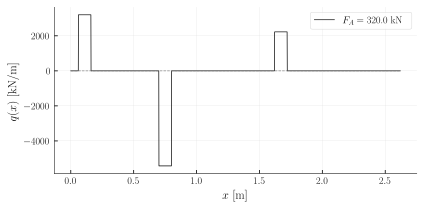

In [17]:
#| label: fig-q_x
#| fig-cap: Verlauf der Einwirkungen und Reaktionskräften
plt.plot(x_array, q_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(q_x)}$ [kN/m]')
plt.legend()
plt.savefig('images/q_x.svg')

plt.show()


Durch Integration der Einwirkung über die Laufvariable $x$ ergibt sich der Verlauf der Querkraft.

$$
V(x) = -\int q(x) \, dx + c_1
$${#eq-vx_integriert}

Mit der Randbedingung $V(0) = 0$ kann die Integrationskonstante bestimmt werden. Der Verlauf der Querkräfte ist in @fig-v_x dargestellt. Nach dem Auflager $B$ ist der Plattenstreifen unbelastet.


In [18]:
eq_V_x = sp.Eq(-V_x,sp.integrate(eq_q_x_num.rhs, x) + c_1)

c_1_num = sp.solve(eq_V_x.rhs.subs(x,0).subs(params),c_1)[0]

V_x_solve = eq_V_x.subs(c_1, c_1_num).simplify()

V_x_lamb = sp.lambdify((F_A,x),V_x_solve.rhs, 'numpy')

V_x_array =[]
for Last in Laststufen:
    V_x_array.append(V_x_lamb(Last,x_array))

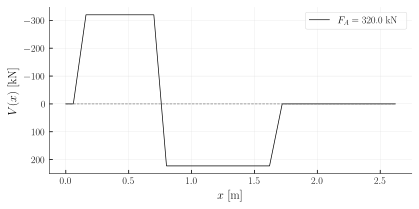

In [19]:
#| label: fig-v_x
#| fig-cap: Verlauf der Querkräfte 

plt.plot(x_array, V_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(V_x)}$ [kN]')
plt.legend()
plt.savefig('images/V_x.svg')

plt.show()


Der Verlauf des Biegemoments lässt sich durch Integration der Querkräfte bestimmen:

$$
M(x) = \int V(x) \, dx + c_2
$${#eq-m_x_a3v2}

Mit der Randbedingung $M(0) = 0$ kann die Integrationskonstante bestimmt werden. Der Verlauf der Biegemomente ist in @fig-m_x dargestellt. Es ergibt sich ein Minimum über dem Auflager $C$.


In [20]:
eq_M_x = sp.Eq(M_x, sp.integrate(V_x_solve.rhs,x)+c_2)
c_2_num = sp.solve(eq_M_x.subs(x,0).rhs.subs(params), c_2)[0]
M_x_solve = eq_M_x.subs(c_2, c_2_num).simplify()
M_x_lamb = sp.lambdify((F_A, x),M_x_solve.rhs, 'numpy')


M_x_array = []
for Last in Laststufen:
    M_x_array.append(M_x_lamb(Last, x_array))


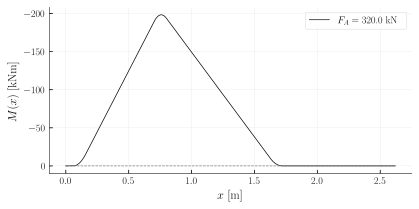

In [21]:
#| label: fig-m_x
#| fig-cap: Verlauf der Biegemomente 

plt.plot(x_array, M_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [kNm]')
plt.legend()
plt.savefig('images/M_x.svg')

plt.show()

Zusätzlich zu den resultierenden Biegemomenten aus der Einwirkung kann ein durch die Längszugkraft aus der Querkraft induziertes Biegemoment ermittelt werden. Dies wird mit einem Versatzmass berücksichtigt. Die Gleichung @eq-versatzmass zeigt die Ermittlung des Versatzmass. Multipliziert mit der statischen Höhe ergibt sich der Versatz des Biegemoments aus @eq-versatzmoment. 
$$
h_{versatz} = \frac{V \cdot \cot(\theta_{c3})}{2}
$${#eq-versatzmass}

$$
M_{versatz} = \frac{V \cdot \cot(\theta_{c3})}{2} \cdot z
$${#eq-versatzmoment}

In @fig-m_x_versatz ist die Erhöhung durch das Versatzmass gezeigt. Beim Momentenminimum bildet sich ein Plateau aus. Der notwendige Hebelarm der inneren Kräfte anhand der statischen Höhe $d$ abgeschätzt. Die statische Höhe ist in @fig-qs_vereinfachung dargestellt.

In [22]:
theta_c3_num = params[theta_c3]  # in Grad

eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = eq_d.subs(params)
Eq_list.append(eq_d_num)

    
# Abschätzung des inneren Hebelarms anhand der mittleren statischen Höhe
eq_z_schaetzung = sp.Eq(z, 0.9 * d)
eq_z_schaetzung_num = eq_z_schaetzung.subs(d, eq_d_num.rhs)


# Bestimmung des Versatzmasses
h_versatz = (
    abs(V_x) * sp.cot(sp.rad(theta_c3_num)) / 2 * eq_z_schaetzung_num.rhs.args[0] / 1000
)
h_versatz_lamb = sp.lambdify((V_x), h_versatz, "numpy")

h_versatz_array = []
for V_x in V_x_array:
    h_versatz_array.append(h_versatz_lamb(V_x))

In [23]:
display(eq_d, eq_d_num.evalf(3))

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 162.0⋅millimeter

Daraus folgt der Hebelarm der inneren Kräfte $z$.

In [24]:
display(eq_z_schaetzung, eq_z_schaetzung_num.evalf(3))

z = 0.9⋅d

z = 146.0⋅millimeter

Die Wahl der Neigung der Druckstrebe entspricht dem unteren Grenzwert der @SIA2013a.

In [25]:
display(Markdown(f'$$\n \\theta_{{c3}} = {theta_c3_num}° \n$$'+'{#eq-theta_c3}'))


$$
 \theta_{c3} = 30.0° 
$${#eq-theta_c3}

Daraus folgt der Verlauf der Biegemomente mit dem Versatzmass, dargestellt ist dies in @fig-m_x_versatz.

In [26]:
def calculate_m_c_versatz(mx, versatz):
    
    mx_sol_list = []
    minimum = min(mx)
    for i in range(0,len(mx)):
        if (mx[i] - versatz[i]) <= minimum:
            mx_sol =  minimum
            
        else:
            mx_sol = mx[i]-versatz[i]
        mx_sol_list.append(mx_sol)
    
    return mx_sol_list
    
M_x_array_versatz = []
for i in range(0,len(M_x_array)):
    
    mx_versetzt = calculate_m_c_versatz(M_x_array[i], h_versatz_array[i])
    M_x_array_versatz.append(np.array(mx_versetzt))

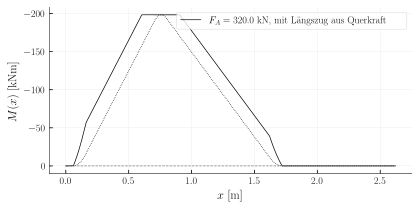

In [27]:
#| label: fig-m_x_versatz
#| fig-cap: Verlauf der Biegemomente mit Längszugkraft aus Querkraft
plt.plot(x_array, M_x_array[-1]/1000, color='black', linestyle='dotted')
plt.plot(x_array, M_x_array_versatz[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN, mit Längszug aus Querkraft')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [kNm]')
plt.legend()
plt.savefig('images/M_x_versatz.svg')

plt.show()

In [28]:
eq_phi_x = sp.Eq(phi_x, sp.integrate(M_x_solve.rhs/EI,x)+c_3)


#### Verdrehung- und Verformungslinien

Wie in @sec-kontinua hergeleitet, sind die Gleichgewichtsbetrachtungen nicht ausreichend um die Verdrehung und Verformung zu beschreiben. Die Werkstoffbeziehung bedingt eine Biegesteifigkeit. Dabei wird von einer konstanten Biegesteifigkeit ausgegangen. Unter Annahme eines ungerissenen Betonquerschnitts lässt sich die Biegesteifigkeit wie folgt berechnen:

In [29]:
eq_EI = sp.Eq(EI, E_c * b*h**3/12)
eq_EI_num = eq_EI.subs(params)
Eq_list.append(eq_EI_num)


In [30]:
display(eq_EI, unit.convert_to(eq_EI_num.evalf(3), [unit.kilonewton, unit.meter]))

            3
     E_c⋅b⋅h 
EI = ────────
        12   

                             2
EI = 2.07e+4⋅kilonewton⋅meter 

Der Verlauf der Verdrehung entspricht dem integrierten Verlauf der Biegemomente, dividiert durch die Biegesteifigkeit.

$$
\varphi(x) = \frac{1}{EI}\int M(x) \, dx + c_3
$${#eq-verdrehung}

Die Verformung hingegen entspricht dem integrierten Verlauf der Verdrehung.

$$
w(x) = \int -\varphi(x) \, dx + c_4
$${#eq-verformung}

Mit den Randbedingungen $w(C) = 0$ und $w(B) = 0$ können die Integrationskonstanten bestimmt werden. Die elastische Verformung, bzw. die Verformung mit einer konstanten Biegesteifigkeit bestimmt, ist in @fig-w_x dargestellt.



In [31]:
eq_w_x = sp.Eq(w_x, -sp.integrate(eq_phi_x.rhs, x)+ c_4)
eq_w_x.subs(params_plot)
c_solve = sp.solve([eq_w_x.rhs.subs(x,a_1 + a_2).subs(params_plot), eq_w_x.rhs.subs(x,a_1 + a_2+a_3).subs(params_plot)],[c_3, c_4])


eq_w_x_solve = eq_w_x.subs(c_solve).subs(params_plot)


w_x_lamb = sp.lambdify((F_A,x, EI),eq_w_x_solve.rhs)

In [32]:
w_x_array_ungerissen = []
for Last in Laststufen:
    w_x_array_ungerissen.append(w_x_lamb(Last, x_array, np.float64(eq_EI.rhs.subs(params_plot))))



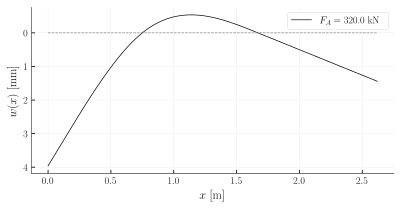

In [33]:
#| label: fig-w_x
#| fig-cap: Verlauf der Verformung für eine konstante ungerissene Biegesteifigkeit

plt.plot(x_array, w_x_array_ungerissen[-1]*1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')
plt.gca().invert_yaxis()

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(w_x)}$ [mm]')
plt.legend()
plt.savefig('images/w_x.svg')

plt.show()

In [34]:
w_1_elastisch_ungerissen = []
for Last in Laststufen:
    w_1_elastisch_ungerissen.append(w_x_lamb(Last, 0.11, np.float64(eq_EI.rhs.subs(params_plot))))
eq_w_1_elastisch = sp.Eq(w_1,unit.convert_to(w_1_elastisch_ungerissen[-1]*unit.m,unit.mm))


Eq_list.append(eq_w_1_elastisch)


## Mohrsche Analogie

Das Vorgehen ist in @sec-mohrsche_analogie beschrieben. Der bereits bestimmte Momentenverlauf gemäss @fig-m_x, dividiert durch die ungerissene Biegesteifigkeit, ist als Einwirkung auf das System anzusetzen. Dies ist in @fig-q_x_mohr dargestellt.


In [35]:
eq_q_x_mohr = sp.Eq(q_x_a, M_x_solve.rhs / EI)
eq_q_x_mohr_num = eq_subs(eq_q_x_mohr, eq_EI).subs(params_plot)
q_x_mohr_lamb = sp.lambdify((F_A, x), eq_q_x_mohr_num.rhs, 'numpy')

In [36]:
q_x_mohr_array =[]
for Last in Laststufen:
    q_x_mohr_array.append(q_x_mohr_lamb(Last, x_array))
    
    
    

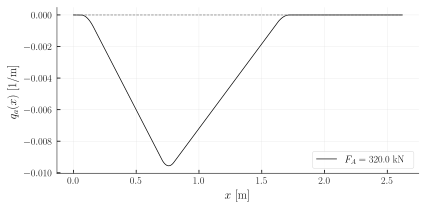

In [37]:
#| label: fig-q_x_mohr
#| fig-cap: Verlauf der Einwirkungen auf das analoge System
plt.plot(x_array, q_x_mohr_array[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(q_x_a)}$ [1/m]')
plt.legend()
plt.savefig('images/q_x_mohr.svg')

plt.show()

Die Randbedingungen bzw. die Lagerungen für das analoge System sind zu ermitteln. Dies kann grundsätzlich mit den Lagerungsbedingungen aus @fig-randbedingungen_analogiesysteme erfolgen. Dabei sind die folgenden Überlegungen zu berücksichtigen. Es ist bekannt, dass die Verformung an den Auflagern null sein muss. Daher ist es notwendig, ein Biegegelenk an den Positionen der Lager einzufügen. Durch die Einspannungen an den Stabrändern resultiert der passende Verformungsverlauf.

![Analoges System mit entsprechender Einwirkung und Lagerungsbedingungen](../images/System_analog.svg){#fig-system_analog}

In [38]:
eq_V_x_mohr = sp.Eq(V_x_a, -sp.integrate(eq_q_x_mohr_num.rhs, x)+c_1)
eq_M_x_mohr = sp.Eq(M_x_a, sp.integrate(eq_V_x_mohr.rhs, x)+c_2)
randbedingung_1 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1 +a_2),0).subs(params_plot)
randbedingung_2 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1 +a_2+a_3),0).subs(params_plot)

c_a_solve = sp.solve([randbedingung_1, randbedingung_2],[c_1,c_2])
c_a_solve
eq_V_x_mohr_subs = eq_V_x_mohr.subs(c_a_solve)
eq_M_x_mohr_subs = eq_M_x_mohr.subs(c_a_solve)


V_x_mohr_lamb = sp.lambdify((F_A,x), eq_V_x_mohr_subs.rhs, 'numpy')
M_x_mohr_lamb = sp.lambdify((F_A,x), eq_M_x_mohr_subs.rhs, 'numpy')

In [39]:
V_x_mohr_array =[]
M_x_mohr_array =[]
for Last in Laststufen:
    V_x_mohr_array.append(V_x_mohr_lamb(Last,x_array))
    M_x_mohr_array.append(M_x_mohr_lamb(Last,x_array))

Der Querkraftverlauf für das analoge System ist in @fig-v_x_mohr dargestellt. Die Querkraft ist einheitslos, da sie die Verdrehung repräsentiert.

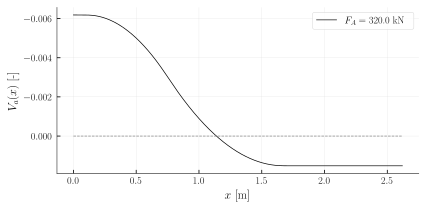

In [40]:
#| label: fig-v_x_mohr
#| fig-cap: Verlauf der Querkräfte für das Analogiesystem

plt.plot(x_array, V_x_mohr_array[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(V_x_a)}$ [-]')
plt.legend()
plt.savefig('images/V_x_mohr.svg')

plt.show()


Der Biegemomentenverlauf für das analoge System ist in @fig-m_x_mohr dargestellt. Der Momentenverlauf entspricht der Verformung und ist daher in [mm] angegeben.


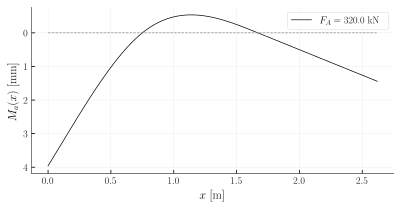

In [41]:
#| label: fig-m_x_mohr
#| fig-cap: Verlauf der Biegemomente für das Analogiesystem

plt.plot(x_array, M_x_mohr_array[-1]*1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x_a)}$ [mm]')
plt.legend()
plt.savefig('images/w_x_mohr.svg')

plt.show()

## Abschätzung nach Norm
Nach der Bestimmung der elastischen Verformung kann die Verformung anhand des vollständig gerissenen Querschnitts gemäss @SIA2013a ermittelt werden. Ohne Druckbewehrung und Kriecheinflüsse ergibt sich die folgende Gleichung:

$$
w_{1II,SIA} = \frac{0.75}{10\rho^{0.7}}\left(\frac{h}{d}\right)^3 w_1
$${#eq-w_1_II_sia}

Der geometrische Bewehrungsgehalt definiert sich folgendermassen.

In [42]:
eq_rho = sp.Eq(rho, A_s/(b*d))
Eq_list.append(eq_rho)
display(eq_rho)

     Aₛ
ρ = ───
    b⋅d

Die Querschnittsfläche der Stäbe in der Zugzone entsprechen dem Folgenden.

In [43]:
eq_A_s = sp.Eq(A_s, sp.Mul(2*b,sp.pi * diam_s **2 / (4 * s_x), evaluate=False))
eq_A_s_num = unit.convert_to(eq_A_s.subs(params), unit.mm)
Eq_list.append(eq_A_s_num)
display(eq_A_s, eq_A_s_num.evalf(4))

                   2
         π⋅\oslashₛ 
Aₛ = 2⋅b⋅───────────
             4⋅sₓ   

                      2
Aₛ = 2262.0⋅millimeter 

Die bereits ermittelte statische Höhe, dargestellt in @fig-qs_vereinfachung, beträgt:

In [44]:

display(eq_d_num.evalf(3))


d = 162.0⋅millimeter

Damit lässt sich abschliessend die Verformung mittels der Abschätzformel für die maximale Laststufe bestimmen.

In [45]:
eq_w_1_gerissen_norm = sp.Eq(w_1_gerissen_norm, sp.Mul(0.75/(10*rho)**sp.Rational(0.7) , (h/d)**3 * w_1, evaluate=False))
eq_w_1_gerissen_norm_num = unit.convert_to(eq_subs(eq_w_1_gerissen_norm, *Eq_list).subs(params), unit.mm)
Eq_list.append(eq_w_1_gerissen_norm_num)

w_1_gerissen_norm_lamb = sp.lambdify((w_1),eq_w_1_gerissen_norm.rhs.subs(rho, eq_rho.rhs).subs(d, eq_d_num.rhs.args[0]).subs(A_s, eq_A_s_num.rhs).subs(params).subs(unit.mm,1), 'numpy')

display(eq_w_1_gerissen_norm_num.evalf(3))

w_1_II,SIA = 15.7⋅millimeter

## Numerische Integration der Krümmung


### Grundlagen

Um sich von der Betrachtung einer konstanten Biegesteifigkeit zu lösen, hilft die Anwendung einer verfeinerten Momenten-Krümmungsbeziehung. Im Folgenden wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Schubbewehrung ist in @fig-qs_a3 nicht dargestellt.

![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch_A3.svg){#fig-qs_a3}


Der Querschnitt wird wie folgt vereinfacht:


![Vereinfachung der Bewehrungsführung](../images/QS_analyse_1.svg){#fig-qs_vereinfachung}

Die Parameter aus der @tbl-params_krummung finden Einfluss in die Berechnungen.

In [46]:
#| label: tbl-params_krummung
#| tbl-cap: Versuchsparameter für die verfeinerte Momenten-Krümmungsbeziehung


dict_to_table(params_krummung)

|  Parameter  | ​  |
|---|---|
| $E_{s} = \frac{200000.0 \text{N}}{\text{mm}^{2}}$ | $\oslash_{s} = 12.0 \text{mm}$ |
| $c_{nom} = 20.0 \text{mm}$ | $f_{cc} = \frac{58.8 \text{N}}{\text{mm}^{2}}$ |
| $f_{su} = \frac{630.3 \text{N}}{\text{mm}^{2}}$ | $f_{sy} = \frac{546.0 \text{N}}{\text{mm}^{2}}$ |
| $s_{x} = 80.0 \text{mm}$ | $\theta_{c3} = 30.0$ |
| $\varepsilon_{cu} = 0.005$ | $\varepsilon_{su} = 0.1117$ |


Neben den Parametern wird das Stoffgesetz für den Betonstahl in @fig-stahlkennlinie hinterlegt. Das bilineare, bzw. linear-elastisch linear-plastische Spannungs-Dehnungsdiagramm für den Betonstahl hält den Rechenaufwand klein und liefert eine ausreichende Genauigkeit. Eine Berücksichtigung des verfestigenden Verhaltens ist essentiell, um die Verformungen nach dem Fliessen des Betonstahls näherungsweise zu bestimmen. Das Diagramm ist definiert bis zur Bruchdehnung des Stahls. Das Verhalten gilt ebenso im negativen Spannungs-Dehnungs Bereich.

In [47]:
eq_1 = sp.Eq(f_sy, a +b*f_sy/E_s)
eq_2 = sp.Eq(f_su, a + b*epsilon_su)



eq_lin = sp.Eq(sigma_epsilon_s, a + b * epsilon_s).subs(sp.solve([eq_1,eq_2],[a,b]))

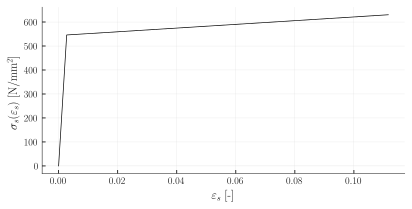

In [48]:
#| label: fig-stahlkennlinie
#| fig-cap: Spannungs-Dehnungs Diagramm des Betonstahls linear-elastisch linear-plastisch


eq_sigma_epsilon_s = sp.Eq(sigma_epsilon_s, sp.Piecewise(
    (E_s * epsilon_s, (epsilon_s<=f_sy / E_s)&(epsilon_s>=0)),
    (eq_lin.rhs.subs(params_plot), (epsilon_s<=epsilon_su)&(epsilon_s>=f_sy / E_s))
    ))




eq_sigma_epsilon_s_num = eq_sigma_epsilon_s.subs(params_plot) 

eq_sigma_epsilon_s_lamb = sp.lambdify((epsilon_s),eq_sigma_epsilon_s_num.rhs)


epsilon_s_array = np.linspace(0, np.float64(epsilon_su.subs(params_plot)), 2000)
eq_sigma_epsilon_array = eq_sigma_epsilon_s_lamb(epsilon_s_array)


plt.plot(epsilon_s_array, eq_sigma_epsilon_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_s)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_s)}$ [N/mm$ ^2$]')
plt.savefig('images/spannung_dehnung_stahl.svg')

plt.show()

In [49]:
eq_sigma_epsilon_c = sp.Eq(sigma_epsilon_c,sp.Piecewise((E_c * epsilon_c, (epsilon_c <=f_ct/E_c)&(epsilon_c >-f_c/E_c)), (-f_c, epsilon_c< -f_c/E_c)))


eq_sigma_epsilon_c_num = eq_sigma_epsilon_c.subs(params_plot)



Die Betonkennlinie, die in @fig-betonkennlinie dargestellt ist, zeigt ein linear-elastisches ideal-plastisches Verhalten. Im positiven Bereich lässt sich die Betonspannung bis zur Betonzugfestigkeit erhöhen, im negativen Spannungsbereich beginnt ein Plastifizieren beim Erreichen der Betondruckfestigkeit. Dies ist bis zur Bruchstauchung definiert.

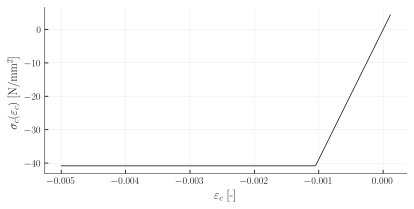

In [50]:
#| label: fig-betonkennlinie
#| fig-cap: Spannungs-Dehnungs Diagramm des Betons linear-elastisch ideal-plastisch


eq_sigma_epsilon_c_lamb = sp.lambdify((epsilon_c),eq_sigma_epsilon_c_num.rhs)


epsilon_c_array = np.linspace(-np.float64(epsilon_cu.subs(params_plot)), np.float64(epsilon_cu.subs(params_plot)), 2000)
eq_sigma_epsilon_c_array = eq_sigma_epsilon_c_lamb(epsilon_c_array)


plt.plot(epsilon_c_array, eq_sigma_epsilon_c_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_c)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_c)}$ [N/mm$ ^2$]')
plt.savefig('images/spannung_dehnung_beton.svg')

plt.show()

### Querschnittsanalyse

Folgend wird eine Querschnittsanalyse durchgeführt. Dabei wird der Querschnitt vor dem Reissen, nach dem Reissen, beim Fliessen der Zugbewehrung und beim Versagen untersucht. Durch die Wahl aussagekräftiger Zustände im Querschnitt lässt sich eine Momentenkrümmungsbeziehung mit überschaubarem Rechenaufwand ermitteln.

#### Schwerpunkt des Querschnitts

Die Bestimmung der Wertigkeit $n$ ermöglicht die Betrachtung des Querschnitts als homogenen Betonquerschnitt. Dies findet Einfluss bei der Schwerpunktsbestimmung, sowie bei der Bestimmung des Flächenträgheitmoments.

In [51]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
Eq_list.append(eq_n_num)



display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.14

Mithilfe der Querschnittsfläche der Zugstäbe, sowie der Betonquerschnittsfläche lässt sich eine ideelle Querschnittsfläche ermitteln. Diese entspricht der Fläche eines reinen Betonquerschnitts. Die Querschnittsfläche der Zugstäbe ist die folgende:

In [52]:


display(eq_A_s, eq_A_s_num.evalf(4))

                   2
         π⋅\oslashₛ 
Aₛ = 2⋅b⋅───────────
             4⋅sₓ   

                      2
Aₛ = 2262.0⋅millimeter 

Die Betonquerschnittsfläche beträgt:

In [53]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(eq_A_c.subs(params), unit.mm)

Eq_list.append(eq_A_c_num)

display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                         2
A_c = 160000.0⋅millimeter 

und die ideelle Querschnittsfläche resultiert zu:

In [54]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(eq_subs(eq_Ai, *Eq_list), unit.mm)

Eq_list.append(eq_Ai_num)

display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                        2
Aᵢ = 169372.0⋅millimeter 

Der vertikale Abstand von der Oberkante zum Schwerpunkt, vergleiche @fig-qs_a3 , beträgt:

In [55]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(eq_subs(eq_zeta_c, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_zeta_c_num)
display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 96.6⋅millimeter

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Stäbe sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [56]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(eq_subs(eq_I_1, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_I_1_num)
display(eq_I_1, eq_I_1_num.evalf(3))


                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 5.67e+8⋅millimeter 

#### Ungerissen - Zustand 1

Durch das durchwegs elastische Verhalten kann die Biegesteifigkeit anhand des Elastizitätmoduls des Betons und des Flächenträgheitmoments des ideellen Querschnitts bestimmt werden.

In [57]:
eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = eq_subs(eq_EI_1, *Eq_list).subs(params)

Eq_list.append(eq_EI_I_num)


In [58]:

display(eq_EI_1, unit.convert_to(eq_EI_I_num.evalf(4),[unit.kilonewton, unit.meter]))

EI__I = E_c⋅I__I

                                 2
EI__I = 2.206e+4⋅kilonewton⋅meter 

##### Rissmoment

Das Rissmoment definiert den Endpunkt des Zustands I im Momentenkrümmungsdiagramm. Dabei gilt die Modellierung gemäss @fig-qs2. Die Spannung in den Zugstäben wird vernachlässigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_analyse_2.svg){#fig-qs2}


Die Betonspannung lässt sich anhand der über die Querschnittshöhe linear verlaufenden Spannung bestimmen.

In [59]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_1,f_ct / zeta_c * (h-zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(eq_subs(eq_sigma_c_inf1,*Eq_list).subs(params),unit.mm)

Eq_list.append(eq_sigma_c_inf1_num)
display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))


        f_ct⋅(h - ζ_c)
σ_c_1 = ──────────────
             ζ_c      

        4.86⋅newton
σ_c_1 = ───────────
                  2
        millimeter 

Zur Bestimmung des Rissmoments gilt es den Hebelarm der inneren Kräfte zu bestimmen, sowie die Betondruckkraft:

In [60]:
eq_z_r = sp.Eq(z_1, h - ((h-zeta_c)/3 + c_nom + 3/2 * diam_s))
eq_z_r_num = unit.convert_to(eq_subs(eq_z_r, *Eq_list).subs(params), unit.mm)
Eq_list.append(eq_z_r_num)
display(eq_z_r, eq_z_r_num.evalf(3))

                            2⋅h   ζ_c
z₁ = -1.5⋅\oslashₛ - cₙₒₘ + ─── + ───
                             3     3 

z₁ = 128.0⋅millimeter

Die Betondruckkraft ist definiert nach:

In [61]:
eq_F_c_r = sp.Eq(F_c1,  sigma_c_1 * b * (h-zeta_c)/2)
eq_F_c_r_num = eq_subs(eq_F_c_r, *Eq_list).subs(params)

Eq_list.append(eq_F_c_r_num)
display(eq_F_c_r, unit.convert_to(eq_F_c_r_num.evalf(3), unit.kilonewton))


        b⋅σ_c_1⋅(h - ζ_c)
F_c,1 = ─────────────────
                2        

F_c,1 = 201.0⋅kilonewton

Und das Rissmoment resultiert schliesslich zu:

In [62]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = eq_subs(eq_M_r, *Eq_list)
Eq_list.append(eq_M_r_num)


In [63]:

display(eq_M_r, unit.convert_to(eq_M_r_num.evalf(4), [unit.kilonewton, unit.meter]))

Mᵣ = F_c,1⋅z₁

Mᵣ = 25.63⋅kilonewton⋅meter

Unter Berücksichtigung der Biegesteifigkeit lässt sich die Krümmung beim Reissen des Querschnitts bestimmen.

In [64]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(eq_subs(eq_chi_r, *Eq_list), unit.m)

Eq_list.append(eq_chi_r_num)
display(eq_chi_r,eq_chi_r_num.evalf(3))

          Mᵣ 
\chiᵣ = ─────
        EI__I

        0.00116
\chiᵣ = ───────
         meter 

Die ermittelte Krümmung und das Rissmoment definieren den Endpunkt des Zustand 1 im Momentenkrümmungsdiagramm.

#### Gerissen Elastisch - Zustand 2

Mit dem Zustand 2 wird darauf abgezielt, den gerissenen Bereich im Momentenkrümmungsdiagramm darzustellen. Der Querschnitt nach dem Reissen ist in der Abbildung @fig-qs3 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton hat ebenfalls seine Druckfestigkeit noch nicht erreicht.

![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_analyse_3.svg){#fig-qs3}


Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe bestimmen. Dazu wird zuerst die Beziehung zwischen der Betonstahlspannung und der Betonstahlkraft dargestellt.




In [65]:
eq_F_s2 = sp.Eq(F_s2, sigma_s_2*A_s)
Eq_list.append(eq_F_s2)
display(eq_F_s2)


F_s,2 = Aₛ⋅σₛ ₂

Die Betonstahlspannung für linear elastisches Verhalten folgt zu:

In [66]:
eq_sigma_s_2 = sp.Eq(sigma_s_2, epsilon_s2 * E_s)
Eq_list.append(eq_sigma_s_2)
eq_sigma_s_2

σₛ ₂ = Eₛ⋅varepsilonₛ₂

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3 beträgt:


In [67]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_2 * b * x_2 /2)
Eq_list.append(eq_F_c2)
eq_F_c2


        b⋅σ_c_2⋅x₂
F_c,2 = ──────────
            2     

Die Betonspannung ebenfalls bestimmt durch ein linear elastisches Verhalten ist definiert durch:

In [68]:
eq_sigma_c_inf2 = sp.Eq(sigma_c_2, epsilon_c2* E_c)
Eq_list.append(eq_sigma_c_inf2)
eq_sigma_c_inf2

σ_c_2 = E_c⋅varepsilon_c,2

Die Betondehnung anhand des Dehnungsverlaufs in @fig-qs3:

In [69]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s2 /(d-x_2) * x_2)
Eq_list.append(eq_epsilon_c2)
eq_epsilon_c2

                 varepsilonₛ₂⋅x₂
varepsilon_c,2 = ───────────────
                      d - x₂    

Unter der Berücksichtung des horizontalen Gleichgewichts folgt:

In [70]:
eq_ggw_1 = sp.Eq(F_c2, F_s2)
Eq_list.append(eq_ggw_1)
eq_ggw_1

F_c,2 = F_s,2

Durch das Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung und mit $n$ und $\rho$ substituiert, folgt:

In [71]:

display(eq_n, eq_rho)

     Eₛ
n = ───
    E_c

     Aₛ
ρ = ───
    b⋅d

In [72]:
eq_ggw_1_subs = eq_subs(eq_F_c2,eq_sigma_c_inf2, eq_epsilon_c2, eq_ggw_1, eq_F_s2).subs(E_c, E_s/n).subs(sigma_s_2, epsilon_s2 * E_s).subs(A_s, rho*b*d).simplify()
eq_ggw_1_subs

                                            2
                        Eₛ⋅b⋅varepsilonₛ₂⋅x₂ 
Eₛ⋅b⋅d⋅ρ⋅varepsilonₛ₂ = ─────────────────────
                             2⋅n⋅(d - x₂)    

Durch die Auflösung nach $x$ resultiert die Betondruckzonenhöhe:

In [73]:
eq_x_2 = sp.Eq(x_2,sp.solve(eq_ggw_1_subs, x_2)[0])
eq_x_2_num = unit.convert_to(eq_subs(eq_x_2, *Eq_list).subs(params),unit.mm)
Eq_list.append(eq_x_2)
display(eq_x_2, eq_x_2_num.evalf(3))

       ⎛         _______________⎞
x₂ = d⋅⎝-n⋅ρ + ╲╱ n⋅ρ⋅(n⋅ρ + 2) ⎠

x₂ = 55.6⋅millimeter

Die hergeleiteten Beziehungen gelten für den gesamten gerissenen Bereich. Mit der Wahl eines Biegemoments kann die Betonstahldehnung und die erforderliche Krümmung bestimmt werden. Wird das in Zustand 1 ermittelte Rissmoment angesetzt, so lässt sich der Startpunkt des gerissenen Bereichs im Momentenkrümmungsdiagramm bestimmen.

In [74]:
eq_M_2 = sp.Eq(M_2, F_s2 * (d-x_2/3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

display(eq_M_2,eq_M_2_M_r, eq_subs(eq_M_2,eq_M_2_M_r, eq_F_s2, eq_sigma_s_2))

           ⎛    x₂⎞
M₂ = F_s,2⋅⎜d - ──⎟
           ⎝    3 ⎠

M₂ = Mᵣ

                        ⎛    x₂⎞
Mᵣ = Aₛ⋅Eₛ⋅varepsilonₛ₂⋅⎜d - ──⎟
                        ⎝    3 ⎠

Daraus resultiert die Betonstahldehnung und die Betonstahlspannung:

In [75]:
eq_epsilon_s2 = sp.Eq(epsilon_s2,sp.solve(eq_subs(eq_M_2, eq_x_2, eq_sigma_s_2, eq_F_s2, eq_M_2_M_r), epsilon_s2)[0])

eq_epsilon_s2_num = eq_subs(eq_epsilon_s2, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_s2_num)


eq_sigma_s_2_num = eq_subs(eq_sigma_s_2, eq_epsilon_s2_num).subs(params)

display(eq_epsilon_s2_num.evalf(3), eq_sigma_s_2_num.evalf(3))

varepsilonₛ₂ = 0.000395

       79.0⋅newton
σₛ ₂ = ───────────
                 2
       millimeter 

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3 bestimmt werden:

In [76]:
eq_chi_II = sp.Eq(chi_II, epsilon_s2/(d-x_2))
eq_chi_II_num = unit.convert_to(eq_subs(eq_chi_II, eq_x_2_num, eq_d_num, eq_epsilon_s2_num).simplify(), unit.m)
Eq_list.append(eq_chi_II)

display(eq_chi_II,eq_chi_II_num.evalf(3))


             varepsilonₛ₂
\chi__{II} = ────────────
                d - x₂   

             0.00371
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [77]:

eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()
Eq_list.append(eq_EI_II_num)


In [78]:
display(eq_EI_II, unit.convert_to(eq_EI_II_num.evalf(6), [unit.kilonewton, unit.meter]))



               M₂    
EI__{II} = ──────────
           \chi__{II}

                                  2
EI__{II} = 6903.8⋅kilonewton⋅meter 

Mit dem Moment und der Krümmung aus dem Zustand 2 ist der Anfangspunkt für den gerissenen Zustand im Momentenkrümmungsdiagramm definiert.

#### Fliessen der Bewehrung - Zustand 3

Der Zustand 3 entspricht dem Zustand 2. Einzig die Stahlspannung erreicht die Fliessspannung. Dargestellt ist dies in der @fig-qs4 .

![Querschnittsanalyse mit erreichter Fliessspannung im Stab](../images/QS_analyse_4.svg){#fig-qs4}

Durch Gleichgewicht der horizontalen Kräfte folgen die Beziehungen:

In [79]:
eq_sigma_c_inf3 = sp.Eq(sigma_c_3,f_sy / E_s / (d-x_3) *x_3 * E_c)
eq_ggw_fliessen = sp.Eq(A_s * f_sy, x_3 * b * sigma_c_3/2)
display(eq_sigma_c_inf3,eq_ggw_fliessen)

        E_c⋅f_sy⋅x₃
σ_c_3 = ───────────
        Eₛ⋅(d - x₃)

          b⋅σ_c_3⋅x₃
Aₛ⋅f_sy = ──────────
              2     

Aufgelöst nach der Druckzonenhöhe:

In [80]:
eq_x_3 = sp.Eq(x_3,sp.solve(eq_subs(eq_ggw_fliessen, eq_sigma_c_inf3), x_3)[1])
eq_x_3_num = unit.convert_to(eq_subs(eq_x_3, *Eq_list).subs(params), unit.mm).simplify()
Eq_list.append(eq_x_3)

display(eq_x_3, eq_x_3_num.evalf(3))

                ___________________________
     -Aₛ⋅Eₛ + ╲╱ Aₛ⋅Eₛ⋅(Aₛ⋅Eₛ + 2⋅E_c⋅b⋅d) 
x₃ = ──────────────────────────────────────
                     E_c⋅b                 

x₃ = 55.6⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungsdiagramm für den gerissenen Zustand definiert:

In [81]:
eq_M_y = sp.Eq(M_y, A_s * f_sy * (d-x_3/3))
eq_M_y_num =  eq_subs(eq_M_y, *Eq_list).subs(params).simplify()
display(eq_M_y, unit.convert_to(eq_M_y_num.evalf(4), [unit.kilonewton, unit.meter]))

              ⎛    x₃⎞
M_y = Aₛ⋅f_sy⋅⎜d - ──⎟
              ⎝    3 ⎠

M_y = 177.2⋅kilonewton⋅meter

Die Fliessdehnung des Betonstahls entspricht:

In [82]:
eq_epsilon_sy = sp.Eq(epsilon_sy, f_sy / E_s)

Eq_list.append(eq_epsilon_sy)

eq_epsilon_sy.subs(params)

varepsilon_sy = 0.00273

Abschliessend lässt sich die Krümmung für den Zustand 3 bestimmen.

In [83]:
eq_chi_y = sp.Eq(chi_y, epsilon_sy / (d-x_3))


In [84]:

eq_chi_y_num = eq_subs(eq_chi_y, *Eq_list).subs(params).simplify()
Eq_list.append(eq_chi_y_num)
display(eq_chi_y, unit.convert_to(eq_chi_y_num.evalf(3), unit.meter))

         varepsilon_sy
\chi_y = ─────────────
             d - x₃   

         0.0257
\chi_y = ──────
         meter 

Der Zustand 3 beschreibt lediglich den Endpunkt des gerissenen Bereichs im Momenten-Krümmungsdiagramm.

#### Maximaler Biegewiderstand - Zustand 4

Der maximale Biegewiderstand kann durch die Plastifizierung der Betondruckzone bestimmt werden. Vereinfacht wird dem Betonstahl die statische Zugfestigkeit vorausgesetzt, um das verfestigende Verhalten annähernd abzubilden.

![Querschnittsanalyse mit erreichter Zugfestigkeit im Stab und plastifizierter Betondruckzone](../images/QS_analyse_5.svg){#fig-qs5}

Die Druckspannungen sind konstant verteilt angenommen, dazu wird die Druckzonenhöhe um den Faktor 0.85 reduziert. 

In [85]:
eq_ggw_R = sp.Eq(A_s * f_su, sp.Mul(0.85,x_4 * b * f_c, evaluate=False))

display(eq_ggw_R)

Aₛ⋅fₛᵤ = 0.85⋅b⋅f_c⋅x₄

Die Druckzonenhöhe folgt zu:

In [86]:
eq_x_4 = sp.Eq(x_4, sp.solve(eq_ggw_R, x_4)[0])
eq_x_4_num = unit.convert_to(eq_subs(eq_x_4, *Eq_list).subs(params),unit.mm)

Eq_list.append(eq_x_4_num)
display(eq_x_4_num.evalf(3))

x₄ = 51.4⋅millimeter

Damit lässt sich der Hebelarm der inneren Kräfte bestimmen:

In [87]:
eq_z_4 = sp.Eq(z_4, d - 0.425*x_4)
eq_z_4_num = eq_subs(eq_z_4, eq_d_num, eq_x_4_num)
display(eq_z_4, eq_z_4_num.evalf(3))

z₄ = d - 0.425⋅x₄

z₄ = 140.0⋅millimeter

Der maximale Biegewiderstand folgt zu:

In [88]:
eq_M_R = sp.Eq(M_R, A_s * f_su * z_4)
eq_M_R_num = unit.convert_to(eq_subs(eq_M_R, *Eq_list, eq_z_4_num).subs(params),unit.m)

Eq_list.append(eq_M_R_num)
display(eq_M_R, unit.convert_to(eq_M_R_num.evalf(4), unit.kilonewton))

M_R = Aₛ⋅fₛᵤ⋅z₄

M_R = 199.8⋅kilonewton⋅meter

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [89]:
eq_chi_u = sp.Eq(chi_u, epsilon_cu / x_4)
eq_chi_u_num = eq_subs(eq_chi_u, *Eq_list).subs(params)

Eq_list.append(eq_chi_u_num)

display(eq_chi_u, unit.convert_to(eq_chi_u_num.evalf(3), unit.meter))

        varepsilon_cu
\chiᵤ = ─────────────
              x₄     

        0.0974
\chiᵤ = ──────
        meter 

Die Betonstahldehnung darf die Bruchdehnung nicht überschreiten:

In [90]:
eq_epsilon_s4 = sp.Eq(epsilon_s4, epsilon_cu / x_4 * (d-x_4))
eq_epsilon_su_num = eq_subs(eq_epsilon_s4, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_su_num)
display(eq_epsilon_s4, eq_epsilon_su_num.evalf(3))

               varepsilon_cu⋅(d - x₄)
varepsilonₛ₄ = ──────────────────────
                         x₄          

varepsilonₛ₄ = 0.0108

Die Bruchdehnung des Stahls wird nicht erreicht. Der Querschnitt versagt im Druckbereich. Die Annahme, dem Betonstahl die statische Zugfestigkeit zu Grunde zu legen ist grundsätzlich nicht gerechtfertig. Der Vergleich mit den Versuchsergebnissen zeigt jedoch, dass sich diese Annahme bewährt.

In [91]:
eq_epsilon_sw = sp.Eq(epsilon_su,params[epsilon_su])
eq_epsilon_sw

varepsilonₛᵤ = 0.1117

Die Biegesteifigkeit im Bereich 3 beträgt:

In [92]:
eq_EI_III = sp.Eq(EI_III, (M_R)/(chi_u))
eq_EI_III_num = eq_subs(eq_EI_III, *Eq_list).simplify()
display(eq_EI_III, unit.convert_to(eq_EI_III_num.evalf(3), [unit.kilonewton, unit.meter]))

             M_R 
EI__{III} = ─────
            \chiᵤ

                                    2
EI__{III} = 2.05e+3⋅kilonewton⋅meter 

In [93]:
eq_1 = sp.Eq(chi_y, r + m*-M_y)
eq_2 = sp.Eq(chi_u, r + m*-M_R)


eq_solve = sp.solve([eq_1,eq_2],[r,m])

m_solve = eq_solve[m].subs(chi_u, -M_R/EI_III).subs(chi_y,-M_y / EI_II)
r_solve = eq_solve[r].subs(chi_u, -M_R/EI_III).subs(chi_y,-M_y / EI_II)

chi_M_linear = sp.Eq(chi_M,r_solve + m_solve * M)


Der Zustand 4 beschreibt den Endpunkt des Momenten-Krümmungsdiagramm.

#### Momenten-Krümmungsdiagramm

Die definierten Krümmungen mit den entsprechenden Biegemomenten aus der Querschnittsanalyse sind in @fig-mchi_diagramm aufgezeigt. 

In [94]:
eq_chi_M = sp.Eq(chi_M, sp.Piecewise((0,M>=0),(M/ (EI_I), (M < 0) & (M > -eq_M_r.lhs)), (M/(EI_II), (M < -eq_M_r.lhs) & (M > -M_y)), (chi_M_linear.rhs , (M < -M_y) & (M > -M_R))))


In [95]:
M_chi_params = [
                eq_EI_I_num.rhs,
                eq_EI_II_num.rhs,
                eq_EI_III_num.rhs,
                eq_M_r_num.rhs,
                eq_M_y_num.rhs,
                eq_M_R_num.rhs
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


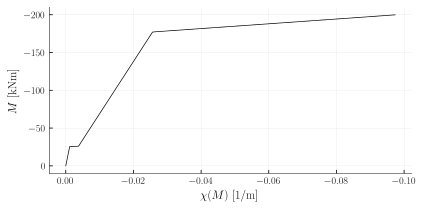

In [96]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich
M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)

chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)

M_array = np.linspace(0,-M_R_num, 500)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)

plt.plot(chi_M_array, M_array/1000, color='black')

# Anmerkungen hinzufügen


plt.annotate('$EI^I$', xy=(0.0009, 15000), xytext=(0, -10), textcoords='offset pixels')
plt.annotate("$EI^{II}$", xy=(0.01, 50000), xytext=(10, 10), textcoords='offset pixels')

plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.savefig('images/momenten_krummung.svg')


plt.show()


Die erste Steigung im Diagramm beschreibt den ungerissenen Zustand. Dieser hat die Neigung von $EI^I$. Darauf folgt eine schlagartige Erhöhung der Krümmung ohne Steigerung des Moments. Dies entspricht dem Übergang vom gerissenen zum ungerissenen Zustand. Dabei steigt der Verlauf mit der Neigung $EI^{II}$ bis zum Fliessen der Bewehrung. Ab diesem Punkt erfolgt ein verfestigendes Verhalten des Betonstahls und ein Plastifizieren der Betondruckzone bis zum Erreichen des Biegewiderstands.

#### Zustandslinien der Krümmung

Der Biegemomentenverlauf $M(x)$, als Eingabe in die Funktion der Krümmung $\chi(M)$, führt zu den Zustandslinien der Krümmung in @fig-chi_x_diagramm. Dargestellt ist der Krümmungsverlauf exemplarisch für die Zustandslinien der Biegemomente aus der @fig-m_x.

In [97]:
chi_M_versuch_2 = []
for M_x in M_x_array:
    chi_M_versuch_2.append(chi_M_lambda(M_x, *M_chi_params))

chi_M_versatz_versuch_2 = []
for M_x in M_x_array_versatz:
    chi_M_versatz_versuch_2.append(chi_M_lambda(M_x, *M_chi_params))


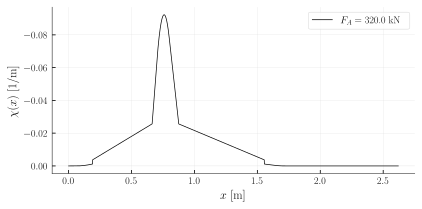

In [98]:
#| label: fig-chi_x_diagramm
#| fig-cap: Krümmungsverlauf entlang der Stabachse

plt.plot(x_array, chi_M_versuch_2[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
# plt.plot(x_array, chi_M_versatz_versuch_2[-1], color='darkgreen', label='Längszugkraft aus Querkraft')


plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.legend()
plt.gca().invert_yaxis()
plt.savefig('images/krummungsverlauf.svg')

plt.show()


Über dem Auflager $C$ ist für die dargestellte Laststufe der Biegewiderstand erreicht. Man befindet sich im Endbereich der Momenten-Krümmungsbeziehung. Ebenfalls ersichtlich ist der sprunghafte Übergang zwischen dem ungerissenen und dem gerissenen Bereich.

#### Punktuelle Bestimmung der Verformung

Unter Anwendung der Arbeitsgleichung kann die Verformung nach @eq-arbeitsgleichung bestimmt werden. Die Wahl der Position der fiktiven Einwirkung entspricht der Position der berechneten Verformung.

$$
w = \int_0^l \bar{M}(x) \cdot \frac{M(x)}{EI} d_x
$${#eq-arbeitsgleichung}

Wobei $\frac{M(x)}{EI} = \chi(x)$ gilt.

Es gilt die Zustandslinien der Krümmung multipliziert mit der Zustandslinie der Biegemomente in @fig-m_x_diagramm_virtuell des virtuellen Kräftezustands über die Stablänge zu integrieren.

In [99]:
M_x_array_fiktiv = M_x_lamb(1,x_array)

def M_fiktiv(x_array):
    index_of_max = np.argmin(M_x_array[-1])
    split_parts = [x_array[:index_of_max+1], x_array[index_of_max+1:]]
    verlauf1 = -split_parts[0]*(0.64/0.75)
    verlauf2 = min(verlauf1) + split_parts[1]*(0.64/0.92) - split_parts[1][0]*(0.64/0.92)
    verlauf2[verlauf2 >0] = 0 #Werte grösser als 0 sind null
    
    M_result = np.concatenate((verlauf1, verlauf2))
    return M_result


M_x_array_fiktiv = M_fiktiv(x_array)

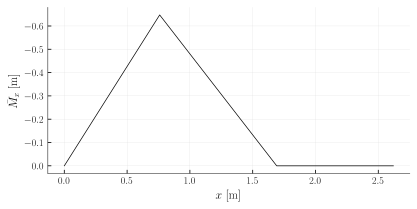

In [100]:
#| label: fig-m_x_diagramm_virtuell
#| fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand

plt.plot(x_array, M_x_array_fiktiv, color='black')
# plt.plot(x_array, M_x_array_versatz[0], color='darkgreen', label='Längszugkraft aus Querkraft')
plt.gca().invert_yaxis()

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel('$\\bar{M}_x$ [m]')
plt.savefig('images/M_virtuell.svg')

plt.show()

In [101]:
w_1_m_chi = []

for i in range(0, len(M_x_array)):
    w_1_m_chi.append(np.trapz(M_x_array_fiktiv*chi_M_versuch_2[i], x_array))
    
    
    
w_1_m_chi_versatz = []

for i in range(0, len(M_x_array)):
    w_1_m_chi_versatz.append(np.trapz(M_x_array_fiktiv*chi_M_versatz_versuch_2[i], x_array))

Für die maximale Last beträgt die Deformation an der Stelle $w_1$ beispielsweise:

In [102]:
eq_w_1_m_chi = unit.convert_to(sp.Eq(w_1,w_1_m_chi[-1]*unit.m), unit.mm)
eq_w_1_m_chi.evalf(3)

w₁ = 15.3⋅millimeter

### Zugversteifung

Die bisherige Betrachtung beschränkt sich auf einen schlagartigen Wechsel von ungerissen zu vollständig gerissen. Dabei wird der Bereich zwischen den Rissen ebenfalls als gerissen angenommen. Mittels der Zugversteifung wird ein theoretischer Rissabstand ermittelt und zwischen den Rissen eine versteifte Wirkung zwischen Betonstahl und Beton angenommen (Verbundwirkung). Dies wird folgend auf das Versuchsbeispiel angewendet. Berücksichtigt wird dies unter dem Ansatz von Marti, beschrieben in @Spathelf2022.

Die Krümmungsdifferenez nach Marti beträgt:

In [103]:
#Formeln

eq_delta_chi_gamma = sp.Eq(delta_chi, sp.Mul(lamb / 2, f_ct * (1-rho_eff)/(rho_eff * E_s*(d-x_2)), evaluate=False))
eq_rho_eff = sp.Eq(rho_eff, (M_r*(d-x_2) * E_s / (f_ct * EI_II)+1-n)**-1)
eq_srm = sp.Eq(s_rm, lamb * diam_s*(1-rho_eff)/(4*rho_eff))
eq_sigma_sr0 = sp.Eq(sigma_sr0, F_s2 / A_s)
eq_w_r = sp.Eq(w_r, s_rm * (2*sigma_sr - lamb * sigma_sr0) / (2*E_s))

# Numerische Werte
eq_w_r_lamb = sp.lambdify((sigma_sr, sigma_sr0,s_rm, lamb, E_s), eq_w_r.rhs)
eq_delta_chi_gamma_num = unit.convert_to(eq_subs(eq_delta_chi_gamma, eq_rho_eff, eq_M_r_num, eq_EI_II_num, eq_n_num, eq_x_2_num, eq_d_num).subs(params), unit.m)
eq_rho_eff_num = eq_subs(eq_rho_eff, *Eq_list).subs(params)
eq_srm_num = eq_subs(eq_srm, eq_rho_eff_num).subs(params)



display(eq_delta_chi_gamma,eq_delta_chi_gamma_num.evalf(3))


Eq_list.extend([eq_delta_chi_gamma, eq_rho_eff, eq_srm,eq_sigma_sr0, eq_w_r])




                λ  f_ct⋅(1 - ρ_eff)
\Delta\chi(λ) = ─⋅─────────────────
                2 Eₛ⋅ρ_eff⋅(d - x₂)

                0.00131⋅λ
\Delta\chi(λ) = ─────────
                  meter  

Der mechanische Bewehrungsgehalt folgt zu:

In [104]:
display(eq_rho_eff, eq_rho_eff_num.evalf(3))

                   1           
ρ_eff = ───────────────────────
                 Eₛ⋅Mᵣ⋅(d - x₂)
        -n + 1 + ──────────────
                 EI__{II}⋅f_ct 

ρ_eff = 0.0753

Eine Abschätzung des Rissabstands in Abhängigkeit ist folgend gezeigt. Dabei sind die Resultate für $\lambda = 1$ und $\lambda = 0.5$ berechnet.

In [105]:
display(eq_srm, eq_srm_num.subs(lamb, 1).evalf(3),eq_srm_num.subs(lamb, 0.5).evalf(3))

      \oslashₛ⋅λ⋅(1 - ρ_eff)
sᵣₘ = ──────────────────────
             4⋅ρ_eff        

sᵣₘ = 36.8⋅millimeter

sᵣₘ = 18.4⋅millimeter

Die Rissbreite ist abhängig von der Betonstahlspannung. Da vor dem Reissen des Betons keine Risse vorhanden sind, darf die Rissspannung von der Betonstahlspannung subtrahiert werden. Die Rissspannung lässt sich anhand der Betonstahlkraft aus dem Zustand 2 bestimmen.

In [106]:
display(eq_sigma_sr0)

       F_s,2
σₛᵣ₀ = ─────
         Aₛ 

Die Bestimmung der Rissbreite ist folgend gezeigt. Für die Stahlspannung wird die Fliessspannung eingesetzt.

In [107]:
display(eq_w_r)

     sᵣₘ⋅(-λ⋅σₛᵣ₀ + 2⋅σₛᵣ)
wᵣ = ─────────────────────
              2⋅Eₛ        

Die Variation des Parameters $\lambda = 1 ; 0.5$ gilt hier ebenfalls.

In [108]:
eq_w_r_num_1 = eq_subs(eq_w_r, eq_srm_num, eq_sigma_sr0, eq_A_s_num, eq_F_s2, eq_sigma_s_2_num).subs(sigma_sr, f_sy).subs(lamb, 1).subs(params)
eq_w_r_num_05 = eq_subs(eq_w_r, eq_srm_num, eq_sigma_sr0, eq_sigma_s_2, eq_F_s2, eq_epsilon_s2_num, eq_EI_II_num, eq_n_num, eq_x_2_num, eq_d_num).subs(sigma_sr, f_sy).subs(lamb, 0.5).subs(params)

display(eq_w_r_num_1.evalf(3),eq_w_r_num_05.evalf(3))

wᵣ = 0.0933⋅millimeter

wᵣ = 0.0485⋅millimeter

Die Resultate sind vergleichbar mit den gemessenen Rissbreiten der Laststufe 12, die in @Jaeger2006 dargestellt sind. Diese liegen in einem Wertebereich von $0.15 \text{ mm}$ bis $0.3 \text{ mm}$.

In [109]:
# def druckzonenhöhe(M, M_chi_params):
#     if abs(M) <= M_chi_params[4]:
#         return eq_x_2_num.rhs.evalf(3).args[0]
    
#     if abs(M) >= M_chi_params[4]:
#         return eq_x_4_num.rhs.evalf(3).args[0]

# # Bestimmt die Druckzone anhand der Querschnittsanalyse
# druckzone_array = np.array([])
# for moment in M_array:
#     druckzone_array = np.append(druckzone_array, druckzonenhöhe(moment, M_chi_params))

# # Gibt den Abstand der Bewehrung zum Dehnungsnullpunkt
# abstand_bew_array = eq_d_num.rhs.args[0]- druckzone_array

# # Gibt die Dehnung der Bewehrung in Abhängigkeit der Krümmung
# epsilon_s_array_rissbreite = abs(chi_M_array) * abstand_bew_array/1000

# # Resultiert zur Spannung anhand der ermittelten Stahldehnung
# sigma_s_array = eq_sigma_epsilon_s_lamb(epsilon_s_array_rissbreite)


# # Rissbreite anhand der Stahlspannung

# w_r_a3v2_array_lager_nord = np.array([0.1,0.1,0.1,0.15,0.3]) 
# w_r_array = eq_w_r_lamb(sigma_s_array, eq_sigma_s_2_num.rhs.subs(params).evalf(3).args[0],eq_srm_num.rhs.evalf(3).subs(lamb,1).args[0], 1, params_plot[E_s])



In [110]:
eq_chi_M_zugversteifung = sp.Eq(chi_M, sp.Piecewise((0,M>=0),(M/ (EI_I), (M < 0) & (M > -eq_M_r.lhs)), (M/(EI_II)+eq_delta_chi_gamma_num.rhs.evalf(3)*unit.m, (M < -eq_M_r.lhs) & (M > -M_y)), (chi_M_linear.rhs , (M < -M_y) & (M > -M_R))))


Unter Berücksichtigung der beiden $\lambda$-Grenzwerte ist der Einfluss der Zugversteifung im Momente-Krümmungsdiagramm in @fig-mchi_diagramm_zugversteifung gezeigt.

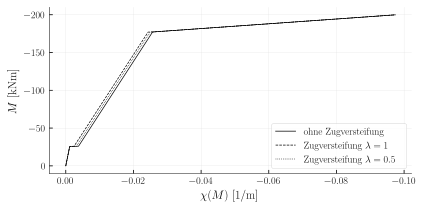

In [111]:
#| label: fig-mchi_diagramm_zugversteifung
#| fig-cap: Momenten-Krümmungsdiagramm mit Zugversteifung ergänzt

eq_chi_M_zugversteifung_lambda = sp.lambdify((M,lamb, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M_zugversteifung.rhs)

chi_M_zugversteifung_array = eq_chi_M_zugversteifung_lambda(M_array,1, *M_chi_params)
chi_M_zugversteifung_array_05 = eq_chi_M_zugversteifung_lambda(M_array,0.5, *M_chi_params)

plt.plot(chi_M_array, M_array/1000, color='black', label='ohne Zugversteifung')
plt.plot(chi_M_zugversteifung_array, M_array/1000, color='black', linestyle='dashed', label='Zugversteifung $\lambda = 1$')
plt.plot(chi_M_zugversteifung_array_05, M_array/1000, color='black', linestyle='dotted',label='Zugversteifung $\lambda = 0.5$')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')
plt.legend()
plt.savefig('images/Momenten_krummung_zugversteift.svg')

plt.show()

Es zeigt sich ein steiferes Verhalten im gerissenen Bereich. Der Einfluss ist relativ gering.

## Fachwerk 



In [112]:
# Specify the file path
file_path_tot = "docs\src\models\deformation_results_FEM_tot_A3.txt"
file_path_tot_var_z = "docs\src\models\deformation_results_FEM_tot_var_z_A3.txt"
file_path_schubbewehrung = "docs\src\models\deformation_results_FEM_schubbewehrung.txt"
file_path_druckstrebe = "docs\src\models\deformation_results_FEM_druckstrebe.txt"
file_path_druckgurt = "docs\src\models\deformation_results_FEM_druckgurt.txt"
file_path_zuggurt = "docs\src\models\deformation_results_FEM_zuggurt.txt"


# Open the file in read mode
with open(file_path_tot, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_tot = np.array([float(line.strip()) for line in file])

# Open the file in read mode
with open(file_path_tot_var_z, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_tot_var_z = np.array([float(line.strip()) for line in file])
    
    
# Open the file in read mode
with open(file_path_zuggurt, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_zuggurt = np.array([float(line.strip()) for line in file])


# Open the file in read mode
with open(file_path_druckgurt, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_druckgurt = np.array([float(line.strip()) for line in file])
    
# Open the file in read mode
with open(file_path_schubbewehrung, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_schubbewehrung = np.array([float(line.strip()) for line in file])

# Open the file in read mode
with open(file_path_druckstrebe, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_druckstrebe = np.array([float(line.strip()) for line in file])


Die bisherigen Analysen beschränken sich auf eine Querschnittsbetrachtung. 
Der Kraftfluss lässt sich mit einem Spannungsfeld detaillierter verfolgen. Eine Einteilung in Parallelfelder und Fächer ist in @fig-spannungsfelder_flach gezeigt. 

![Spannungsfeld mit flacher Feldneigung](../images/Spannungsfelder_flach.svg){#fig-spannungsfelder_flach}

Der Neigungswinkel der Betondruckstrebe wird in Anlehnung an die @eq-v_rds_sia262 zur Bestimmung des Querkraftwiderstands von vertikaler Schubbewehrung, gemäss Ziffer 4.3.3.4.3 @SIA2013a, bestimmt.

$$
V_{Rd,s} = \frac{A_{sw}}{s} z f_{sd} \cot(\alpha)
$${#eq-v_rds_sia262}

Dabei wird die Querschnittsfläche der Schubbewehrung bestimmt.

In [113]:
n_schubbewehrung = 1
diam_schubbewehrung = 6 *unit.mm
n_schnittig = 7

eq_Asw_num = sp.Eq(A_sw, n_schubbewehrung * np.pi * diam_schubbewehrung**2 / 4 * n_schnittig)


eq_Asw_num.evalf(4)

                        2
A_s_w = 197.9⋅millimeter 

Der Hebelarm der inneren Kräfte des Zustands 4 wird angesetzt.

In [114]:
eq_z_4_num.evalf(3)

z₄ = 140.0⋅millimeter

Die Fliessspannung wird mit der Zugfestigkeit $f_{su}$ substituiert. Dies gewährleistet, dass die Schubbewehrung den elastischen Bereich verlässt. Der Querkraftwiderstand wird mit der maximal im System auftretenden Querkraft ersetzt. Abschliessend gilt $\alpha = \theta_{c3}$.

In [115]:
eq_V_R_sia = sp.Eq(V_R_s, A_sw / s_w * z_4 * f_su * sp.cot(theta_c3))
eq_theta_c_3_min = sp.Eq(theta_c3_min, sp.solve(eq_V_R_sia, theta_c3)[0])
eq_theta_c_3_min_num = eq_theta_c_3_min.subs({V_R_s:abs(min(V_x_array[-1]))*unit.N,
                                              s_w:8*unit.cm,
                                              A_sw: eq_Asw_num.rhs,
                                              f_su: params[f_su],
                                              z_4: eq_z_4_num.rhs})

display(eq_theta_c_3_min, eq_theta_c_3_min_num.simplify().evalf(3))

               ⎛ V_R,s⋅s_w  ⎞
θ_c3,min = acot⎜────────────⎟
               ⎝A_s_w⋅fₛᵤ⋅z₄⎠

θ_c3,min = 0.599

In [116]:
sp.Eq(theta_c3_min,unit.convert_to(eq_theta_c_3_min_num.simplify().evalf(3).rhs, unit.degree).evalf(3))

θ_c3,min = 34.3°

Der gewählte Neigungswinkel der Felder in Abbildung @fig-spannungsfelder_flach orientiert sich an dem berechneten Winkel. Ausserdem wurde darauf geachtet, dass alle Felder parallel zueinander angeordnet sind.

Durch das Zusammenfassen der Felder zu Streben resultiert das Fachwerk in @fig-fachwerk_flach. Um aus dem Fachwerkmodell zutreffende Verformungen zu ermitteln, gilt es den Pendelstäben passende Dehnsteifigkeiten zu zuordnen. 

![Spannungsfelder zu einem Fachwerk zusammengeführt](../images/Fachwerk_flach.svg){#fig-fachwerk_flach}

Dem Zuggurt ist die Spannungs-Dehnungsbeziehung gemäss @fig-stahlkennlinie hinterlegt, sowie entspricht die Querschnittsfläche jener der Zugbewehrung.

Die Querschnittsfläche des Druckgurts entspricht der Höhe des plastischen Spannungsblocks des Zustands 4 multipliziert mit der Plattenstreifenbreite. Diese wird als konstant über sämtliche Stäbe des Druckgurtes angenommen. Des Weiteren ist die Spannungs-Dehnungsbeziehung gemäss @fig-betonkennlinie angewendet.

Die Querschnittsfläche der Druckstreben entspricht der Streifenbreite multipliziert mit der Parallelfeldbreite, gezeigt in @fig-spannungsfelder_flach. Für die Diagonalen der nicht zentrierten Fächer ist vereinfacht die gleiche Querschnittsfläche hinterlegt. Dazu gilt die Spannungs-Dehnungsbeziehung gemäss @fig-betonkennlinie.

Die Ständer bilden die Schubbewehrung ab. Die Querschnittsfläche resultiert aus der Anzahl an Schubdübeln im entsprechenden Spannungsfeld. Es gilt die Spannungs-Dehnungsbeziehung gemäss @fig-stahlkennlinie. Die @fig-schubbew_fw_flach zeigt, dass pro Ständer drei Schubdübel umfasst sind.

![Anordnung der Schubbewehrung im Fachwerk mit flacher Neigung](../images/Schubbewehrung_aufteilung_flach.svg){#fig-schubbew_fw_flach}

Am Fachwerkmodell lassen sich die Verformungsanteile aus der Schubbewehrung, der Gurte und der Betondruckstreben ermitteln. Beispielsweise lässt sich der Anteil der Schubbewehrung durch das Setzen der Steifigkeit der übrigen Stäbe auf ein infinit grosses Mass bestimmen. Dargestellt ist dies in @fig-last_verformung_fachwerk.

Verformung für Maximallast zeichnen:

{{< pagebreak >}}

## Modellvergleich

Abgeschlossen wird die Analyse des Dreipunktbiegeversuchs mit einer Gegenüberstellung der angewendeten Methoden. Der Fokus liegt auf der darauf, die experimentell ermittelten Verformungen mit den Verformungen aus den Modellen zu vergleichen.

In [117]:
#Biegemomentenverlauf und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1 = []
chi_x_versuch_2_zugversteifung_lamba_05 = []


for M_x in M_x_array:
    chi_x_versuch_2_zugversteifung_lamba_1.append(eq_chi_M_zugversteifung_lambda(M_x,1, *M_chi_params))
    chi_x_versuch_2_zugversteifung_lamba_05.append(eq_chi_M_zugversteifung_lambda(M_x,0.5, *M_chi_params))

# Verformung w1
w_1_m_chi_zugversteifung_1 = []
w_1_m_chi_zugversteifung_05 = []

for i in range(0,len(M_x_array)):
    w_1_m_chi_zugversteifung_1.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_1[i], x_array))
    w_1_m_chi_zugversteifung_05.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_05[i], x_array))





#Längszugkraft und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1_versatz = []
chi_x_versuch_2_zugversteifung_lamba_05_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_zugversteifung_lamba_1_versatz.append(eq_chi_M_zugversteifung_lambda(M_x,1, *M_chi_params))
    chi_x_versuch_2_zugversteifung_lamba_05_versatz.append(eq_chi_M_zugversteifung_lambda(M_x,0.5, *M_chi_params))

## Verformung w1
w_1_m_chi_zugversteifung_1_versatz = []
w_1_m_chi_zugversteifung_05_versatz = []

for i in range(0,len(M_x_array_versatz)):
    w_1_m_chi_zugversteifung_1_versatz.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_1_versatz[i], x_array))
    w_1_m_chi_zugversteifung_05_versatz.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_zugversteifung_lamba_05_versatz[i], x_array))
    



#konstante Steifigkeit
def chi_M_elastisch(M, EI):
    return M/EI


##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen = []
chi_x_versuch_2_konstant_ungerissen = []

for M_x in M_x_array:
    chi_x_versuch_2_konstant_ungerissen.append(chi_M_elastisch(M_x,np.float64(eq_EI.rhs.subs(params_plot))))
    chi_x_versuch_2_konstant_gerissen.append(chi_M_elastisch(M_x, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))

## Momenten-Krümmungsbeziehung
chi_M_ungerissen = chi_M_elastisch(M_array, np.float64(eq_EI.rhs.subs(params_plot)))
chi_M_gerissen = chi_M_elastisch(M_array, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2)))

## Verformung w1
w_1_elastisch_gerissen = []
for Last in Laststufen:
    w_1_elastisch_gerissen.append(w_x_lamb(Last, 0.11, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))
    
## Verformung w1 Norm
w_1_norm = []
for w in w_1_elastisch_ungerissen:
    w_1_norm.append(w_1_gerissen_norm_lamb(w))
    



#konstante Steifigkeit und Längszugkraft

##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen_versatz = []
chi_x_versuch_2_konstant_ungerissen_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_konstant_ungerissen_versatz.append(chi_M_elastisch(M_x,np.float64(eq_EI.rhs.subs(params_plot))))
    chi_x_versuch_2_konstant_gerissen_versatz.append(chi_M_elastisch(M_x, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))


## Verformung w1
w_1_elastisch_ungerissen_versatz = []
w_1_elastisch_gerissen_versatz = []

for i in range(0,len(M_x_array_versatz)):
    w_1_elastisch_ungerissen_versatz.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_konstant_ungerissen_versatz[i], x_array))
    w_1_elastisch_gerissen_versatz.append(np.trapz(M_x_array_fiktiv * chi_x_versuch_2_konstant_gerissen_versatz[i], x_array))
    
## Verformung w1 Norm
w_1_norm_versatz = []
for w in w_1_elastisch_ungerissen_versatz:
    w_1_norm_versatz.append(w_1_gerissen_norm_lamb(w))    

    
#Versuch Jaeger

w_1_versuch_A3V2 = [2.6, 10.2,10.3,11.5,11.6,13,13.1,14.9,15.1,23.8,24.3,35.4,39.4,40.1]
F_A_versuch_A3V2 = [0,211.3,204.1,241.9,236.8,271.3,260.3,300.6,287.7,324.6,293.5,331.2,325.1,301.8]
    


### Krümmung

Der Modellvergleich wird bei der Beschreibung der Krümmung der unterschiedlichen Modelle gestartet. Aus dem Vergleich der Momentenkrümmungsbeziehung, dargestellt in @fig-mchi_diagramm_vergleich, lassen sich die Biegesteifigkeiten herauslesen. Die Unterschiede des Detaillierungsgrad der Beziehung zwischen den Modellen ist deutlich erkennbar. 

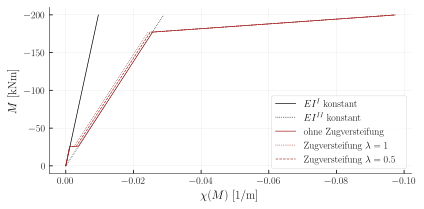

In [118]:
# | label: fig-mchi_diagramm_vergleich
# | fig-cap: Momenten-Krümmungsdiagramm der unterschiedlichen Methoden

plt.plot(
    chi_M_ungerissen,
    M_array / 1000,
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    chi_M_gerissen,
    M_array / 1000,
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(chi_M_array, M_array / 1000, color="brown", label="ohne Zugversteifung")
plt.plot(
    chi_M_zugversteifung_array,
    M_array / 1000,
    color="brown",
    linestyle="dotted",
    label="Zugversteifung $\lambda = 1$",
)
plt.plot(
    chi_M_zugversteifung_array_05,
    M_array / 1000,
    color="brown",
    linestyle="dashed",
    label="Zugversteifung $\lambda = 0.5$",
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel(f"${sp.latex(chi_M)}$ [1/m]")
plt.ylabel(f"${sp.latex(M)}$ [kNm]")
plt.ylim(10, -210)
plt.legend()
plt.savefig("images/momenten_krummung_vergleich.svg")

plt.show()

Die @fig-chi_x_diagramm_vergleich zeigt den Krümmungsverlauf für den Biegemomentenverlauf aus @fig-m_x. Ausgehend davon, dass die erweiterte Momentenkrümmungsbeziehung aus der Querschntitsanalyse den effektiven Krümmungsverlauf präzise abbilden kann,  zeigen die konstanten Biegesteifigkeiten deutliche Abweichungen. Der Fliessbereich über dem Auflager $C$ kann nicht abgebildet werden. Des Weiteren zeigt sich ein ausgeprägter gerissener Bereich, welcher mit der konstanten ungerissenen Biegesteifigkeit als deutlich zu steif eingeschätzt wird.

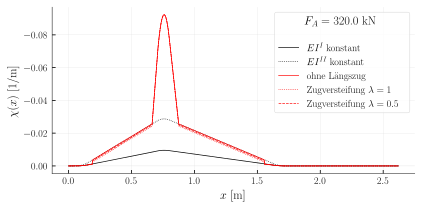

In [119]:
# | label: fig-chi_x_diagramm_vergleich
# | fig-cap: Krümmungsverlauf für die maximale Laststufe ohne Längszugkraft

plt.plot(
    x_array,
    chi_x_versuch_2_konstant_ungerissen[-1],
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    x_array,
    chi_x_versuch_2_konstant_gerissen[-1],
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(
    x_array, chi_M_versuch_2[-1], color="red", linestyle="-", label=f"ohne Längszug"
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_1[-1],
    color="red",
    linestyle="dotted",
    label=f"Zugversteifung $\lambda = 1$",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_05[-1],
    color="red",
    linestyle="dashed",
    label=f"Zugversteifung $\lambda = 0.5$",
)


plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"$\chi(x)$ [1/m]")
plt.legend(title=f"$F_A =$ {Laststufen[-1]/1000} kN\n")
plt.gca().invert_yaxis()
plt.savefig("images/krummungsverlauf_zugversteift.svg")

plt.show()

Das analoge Vorgehen gilt für den Biegemomentenverlauf aus @fig-m_x_versatz. Dargestellt ist der Krümmungsverlauf für diesen in @fig-chi_x_diagramm_laengszugkraft.

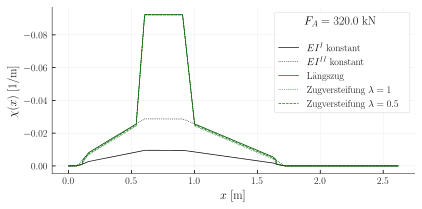

In [120]:
# | label: fig-chi_x_diagramm_laengszugkraft
# | fig-cap: Krümmungsverlauf für die maximale Laststufe mit Längszugkraft durch Querkraft


plt.plot(
    x_array,
    chi_x_versuch_2_konstant_ungerissen_versatz[-1],
    color="black",
    linestyle="-",
    label="$EI^{I}$ konstant",
)
plt.plot(
    x_array,
    chi_x_versuch_2_konstant_gerissen_versatz[-1],
    color="black",
    linestyle="dotted",
    label="$EI^{II}$ konstant",
)


plt.plot(
    x_array,
    chi_M_versatz_versuch_2[-1],
    color="darkgreen",
    linestyle="-",
    label="Längszug",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_1_versatz[-1],
    color="darkgreen",
    linestyle="dotted",
    label=f"Zugversteifung $\lambda = 1$",
)
plt.plot(
    x_array,
    chi_x_versuch_2_zugversteifung_lamba_05_versatz[-1],
    color="darkgreen",
    linestyle="dashed",
    label=f"Zugversteifung $\lambda = 0.5$",
)

plt.xlabel(f"${sp.latex(x)}$ [m]")
plt.ylabel(f"$\chi(x)$ [1/m]")
plt.legend(title=f"$F_A =$ {Laststufen[-1]/1000} kN\n")
plt.gca().invert_yaxis()
plt.savefig("images/krummungsverlauf_zugversteift_laengszugkraft.svg")

plt.show()

Die Schwächen der konstanten Biegesteifigkeiten zeigen sich hier ebenfalls. Auffallend dabei ist der deutlich breitere Fliessbereich aus der detaillierten Momentenkrümmungsbeziehung. Die Verformung resultiert, wie in @eq-arbeitsgleichung beschriebung, aus der Integration des Krümmungsverlaufs. Folglich hat die Verbreiterung im Fliessbereich einen signifikanten Einfluss auf die Verformung.

In [121]:
# | label: fig-last_verformung
# | fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$
def plot_vergleich(border=False, querkraft=False):
    if querkraft == False:
        plt.plot(
            np.array(w_1_elastisch_ungerissen) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="-",
            label="$EI^{I}$ konstant",
        )
        plt.plot(
            np.array(w_1_elastisch_gerissen) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dotted",
            label="$EI^{II}$ konstant",
        )
        plt.plot(
            np.array(w_1_norm) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dashed",
            label="Abschätzung Norm",
        )

        plt.plot(
            np.array(w_1_m_chi) * 1000,
            Laststufen / 1000,
            color="red",
            label="Querschnittsanalyse",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_1) * 1000,
            Laststufen / 1000,
            color="red",
            linestyle="dotted",
            label="Zugversteifung $\lambda = 1$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_05) * 1000,
            Laststufen / 1000,
            color="red",
            linestyle="dashed",
            label="Zugversteifung $\lambda = 0.5$",
        )

    if querkraft == True:
        plt.plot(
            np.array(w_1_elastisch_ungerissen_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="-",
            label="$EI^{I}$ konstant",
        )
        plt.plot(
            np.array(w_1_elastisch_gerissen_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dotted",
            label="$EI^{II}$ konstant",
        )
        plt.plot(
            np.array(w_1_norm_versatz) * 1000,
            Laststufen / 1000,
            color="black",
            linestyle="dashed",
            label="Abschätzung Norm",
        )

        plt.plot(
            np.array(w_1_m_chi_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            label="Querschnittsanalyse und Längszugkraft",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_1_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            linestyle="dotted",
            label="Zugversteifung $\lambda = 1$",
        )
        plt.plot(
            np.array(w_1_m_chi_zugversteifung_05_versatz) * 1000,
            Laststufen / 1000,
            color="darkgreen",
            linestyle="dashed",
            label="Zugversteifung $\lambda = 0.5$",
        )

    plt.plot(
        np.array(w_1_versuch_A3V2) - w_1_versuch_A3V2[0],
        F_A_versuch_A3V2,
        color="blue",
        linestyle="-",
        label="Versuch A3 2.Anordnung",
    )

    if border == True:
        plt.xlim(0, max(np.array(w_1_m_chi_versatz) * 1000))

    plt.xlabel(f"${sp.latex(w_1)}$ [mm]")
    plt.ylabel(f"${sp.latex(F_A)}$ [kN]")
    plt.legend()
    plt.savefig("images/durchbiegung_vergleich.svg")

    plt.show()

### Verformung
Aussagekräfte sind vor allem die Last-Verformungsdiagramme. Diese ermöglichen einen direkten Vergleich mit den gemessenen Verformungen des Versuchs. In @fig-last_verformung_vergleich und @fig-last_verformung_laengszug sind diese für die Biegemomentenverläufe @fig-m_x und @fig-m_x_versatz gezeigt. Welche sich in der Berücksichtigung des Versatzmasses unterscheiden. Die Verformung ist an der Stelle $w_1$ gemessen, vergleiche @fig-system_2_lager.

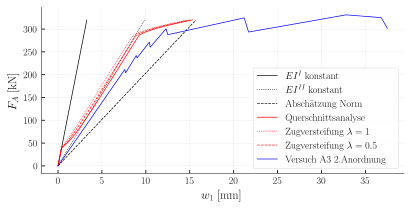

In [122]:
#| label: fig-last_verformung_vergleich
#| fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ 

plot_vergleich()

Es zeigt sich, dass mit einer konstanten ungerissenen Biegesteifigkeit die Verformungen nicht zufriedenstellen abbildbar sind. Bereits im gerissenen Bereich zeigen sich deutliche Abweichungen zu den Versuchsmessungen.

Mit einer konstanten gerissenen Biegesteifigkeit nähert man sich den Versuchsergebnissen an. Die Differenzen zu den Versuchsmessungen steigen mit steigender Laststufe. 

Die Darstellung der Normabschätzung zeigt eine konservative Abschätzung der Verformungen. Die Verformungen werden für sämtliche Laststufen bis zum Erreichen des Fliessbereichs überschätzt.

Bei der Berücksichtigung des verfeinerten Momenten-Krümmungsdiagramms in rot dargestellt, lässt sich das Verformungsverhalten des Versuchs annähernd abbilden. Das Modell bildet ein zu steifes Verhalten ab. Die Zugversteifung wirkt der Modellgenauigkeit entgegen.

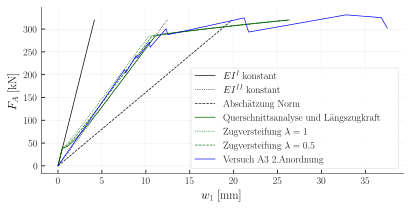

In [123]:
# | label: fig-last_verformung_laengszug
# | fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ mit Längszugkraft aus Querkraft

plot_vergleich(querkraft=True)

Die @fig-last_verformung_laengszug zeigt sämtliche Berechnungsmethoden unter Berücksichtigung der Längszugkraft aus der Querkraft. Es zeigt sich deutlich, dass das Berechnungsmodell mit der Zugversteifung den Versuchsverlauf zufriedenstellend abbildet. Lediglich Abweichungen im Höchstlastbereich sind vorhanden. 

Die Normabschätzung zeigt deutliche Abweichungen zu den gemessenen Verformungen. Zwar liegen diese auf der sicheren Seite, sind jedoch äusserst konservativ.

ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

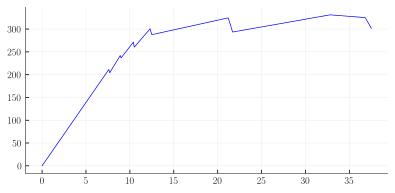

In [129]:
# | label: fig-last_verformung_fachwerk
# | fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ mittels Fachwerkmodell

Laststufen_Fw = np.linspace(1000, 320 * 10**3, 50)


plt.plot(
    np.array(w_1_versuch_A3V2) - w_1_versuch_A3V2[0],
    F_A_versuch_A3V2,
    color="blue",
    linestyle="-",
    label="Versuch A3 2.Anordnung",
)
plt.plot(
    np.array(w_1_fachwerk_tot) * 1000,
    Laststufen_Fw / 1000,
    color="purple",
    linestyle="-",
    label="Gesamtverformung mit Fachwerkmodell, $z = 140$mm",
)

# plt.plot(np.array(w_1_fachwerk_zuggurt)*1000, Laststufen/1000, color='purple',linestyle='dotted', label = 'Anteil Zuggurt')
# plt.plot(np.array(w_1_fachwerk_druckgurt)*1000, Laststufen/1000, color='purple',linestyle='dashed', label = 'Anteil Druckgurt')
# plt.plot(np.array(w_1_fachwerk_schubbewehrung)*1000, Laststufen/1000, color='black',linestyle='-', label = 'Anteil Schubbewehrung')
# plt.plot(np.array(w_1_fachwerk_druckstrebe)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Anteil Druckstrebe')


plt.xlabel(f"${sp.latex(w_1)}$ [mm]")
plt.ylabel(f"${sp.latex(F_A)}$ [kN]")

# plt.xlim(0,max(np.array(w_1_versuch_A3V2)))

plt.legend()
plt.savefig("images/durchbiegung_vergleich_fachwerk.svg")

plt.show()

Das Fachwerkmodell beschreibt den Verlauf ausreichend präzise. Die maximale Deformation, die mit der rechnerisch ermittelten Höhe, sprich dem inneren Hebelarm aus der Querschnittsanalyse, erzielt wird, überschreitet das Ziel bei Weitem. Das Fachwerkmodell reagiert äusserst sensibel auf die gewählte Höhe. Der Verformungsverlauf lässt sich mit einer Fachwerkshöhe von $160\text{ mm}$ präzise abbilden. Ohne Kenntnisse der Versuchsergebnisse wäre jedoch eine präzise Bestimmung der Verformung im Bereich des Fliessens der Zugbewehrung nicht möglich.


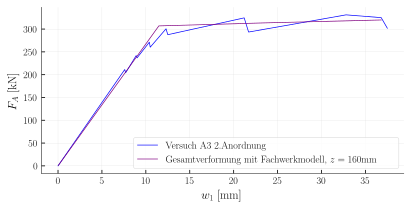

In [130]:
# | label: fig-last_verformung_fachwerk_hoch
# | fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ mittels Fachwerkmodell



plt.plot(
    np.array(w_1_versuch_A3V2) - w_1_versuch_A3V2[0],
    F_A_versuch_A3V2,
    color="blue",
    linestyle="-",
    label="Versuch A3 2.Anordnung",
)


plt.plot(
    np.array(w_1_fachwerk_tot_var_z) * 1000,
    Laststufen_Fw / 1000,
    color="purple",
    linestyle="-",
    label="Gesamtverformung mit Fachwerkmodell, $z = 160$mm",
)

# plt.plot(np.array(w_1_fachwerk_zuggurt)*1000, Laststufen/1000, color='purple',linestyle='dotted', label = 'Anteil Zuggurt')
# plt.plot(np.array(w_1_fachwerk_druckgurt)*1000, Laststufen/1000, color='purple',linestyle='dashed', label = 'Anteil Druckgurt')
# plt.plot(np.array(w_1_fachwerk_schubbewehrung)*1000, Laststufen/1000, color='black',linestyle='-', label = 'Anteil Schubbewehrung')
# plt.plot(np.array(w_1_fachwerk_druckstrebe)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Anteil Druckstrebe')


plt.xlabel(f"${sp.latex(w_1)}$ [mm]")
plt.ylabel(f"${sp.latex(F_A)}$ [kN]")

# plt.xlim(0,max(np.array(w_1_versuch_A3V2)))

plt.legend()
plt.savefig("images/durchbiegung_vergleich_fachwerk.svg")

plt.show()

Des Weiteren zeigt sich, dass die Gesamtverformung primär aus der Verformung der Zugbewehrung resultiert. Die Schubverformung ist für die dünne Platte unbedeutend.